In [16]:
# !pip install pystan
# !pip install fbprophet
# !pip install plotly
# !pip install ipywidgets
"""
ref: prophet docs
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
import json
from fbprophet.serialize import model_to_json, model_from_json


# State %-production share

# MAHARASHTRA 29.59
# MADHYA PRADESH 15.16
# KARNATAKA 13.64
# GUJARAT 6.42
# BIHAR 6.25
# RAJASTHAN 4.80
# ANDHRA PRADESH 5.02
# source: http://agricoop.gov.in/sites/default/files/Monthly%20Report%20on%20Onion%20for%20May%2C%202018.pdf



$$y(t)=g(t)+s(t)+h(t)+\epsilon _t$$
$$g(t)=\frac{C}{1+}$$
$$s(t)=\sum_{n=1}^{N}\bigg(a_n \cos\Big(\frac{2\pi nt}{P}\Big) + b_n \sin\Big(\frac{2\pi nt}{P}\Big)\bigg)$$
$$$$

```

In [17]:
df = pd.read_csv('./../data/full_onion_data.csv')
df = df.drop(['Unnamed: 0', 'DISTRICT', 'MARKET', 'COMMODITY', 'VARIETY', 'GRADE',
       'MIN', 'MAX'], axis= 1)
df['ds'] = df['DATE'].apply(lambda x: datetime.strptime(x, "%d %b %Y"))
df['y'] = df['MODAL'].apply(lambda x: int(x))
df = df.sort_values(by=['ds'])

In [18]:
df.dtypes

MODAL           float64
DATE             object
ds       datetime64[ns]
y                 int64
dtype: object

In [19]:
df.head()

,MODAL,DATE,ds,y
2681,1250.0,01 Jan 2010,2010-01-01,1250
2680,1375.0,02 Jan 2010,2010-01-02,1375
2679,1150.0,04 Jan 2010,2010-01-04,1150
2678,1125.0,05 Jan 2010,2010-01-05,1125
2677,1150.0,07 Jan 2010,2010-01-07,1150


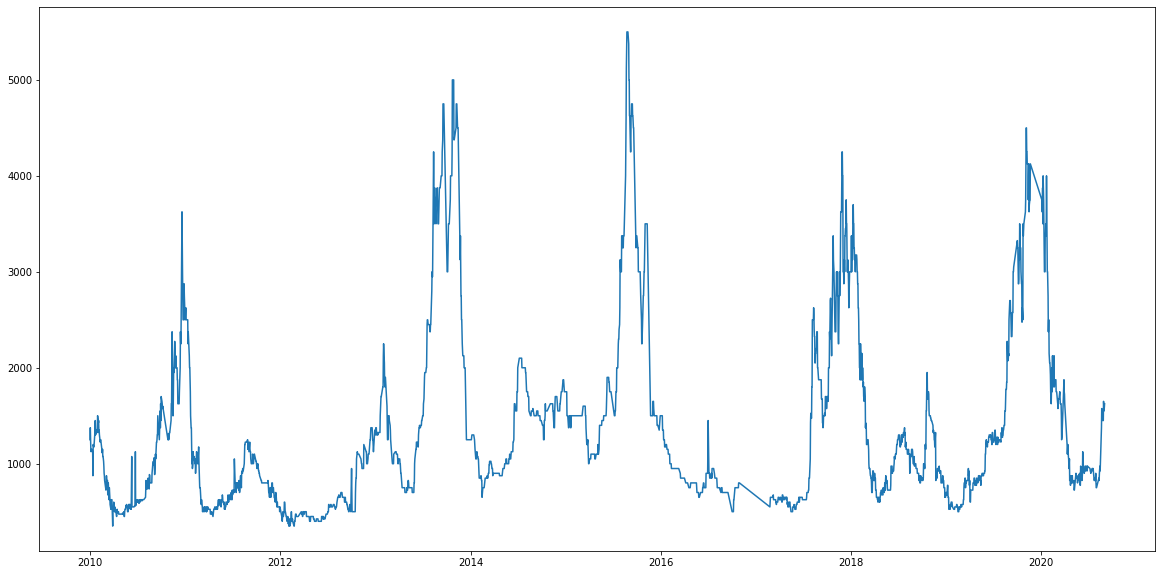

In [20]:
plt.figure(figsize=(20,10))
plt.plot(df['ds'], df['y'])
plt.show()

In [21]:
m = Prophet()
# Prophet.add_country_holidays(m, "India")
m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
future = m.make_future_dataframe(periods=7)
future.tail()

,ds
2684,2020-09-03
2685,2020-09-04
2686,2020-09-05
2687,2020-09-06
2688,2020-09-07


In [23]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
2684,2020-09-03,2473.862178,1605.876057,3328.224944
2685,2020-09-04,2474.328759,1664.380288,3264.003964
2686,2020-09-05,2460.054047,1616.689680,3356.356123
2687,2020-09-06,2515.186900,1739.322443,3418.002171
2688,2020-09-07,2486.313917,1623.619048,3342.178029


In [24]:
# with open('serialized_model.json', 'w') as fout:
#     json.dump(model_to_json(m), fout)  # Save model

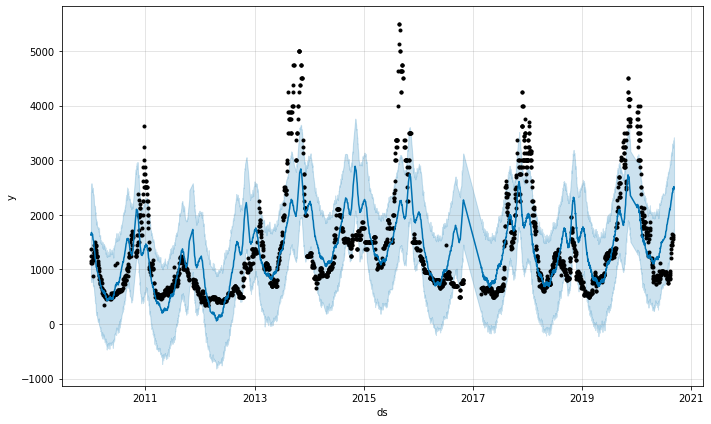

In [25]:
fig1 = m.plot(forecast)

In [26]:
f2 = forecast.copy()
f2['orj'] = pd.Series(df['y'].to_numpy())
def tst(C1, C2, C, D, E):

    for i in range(1, len(forecast)//7-7):
        cnt = 0
        upp = 0
        low = 0
        for j in range((i-1)*7, (i)*7):
            if abs(forecast['yhat_lower'][j]-forecast['yhat_upper'][j])*C1 < abs(forecast['yhat'][j]-df['y'][len(df)-1-j]):
                cnt += 1
            if forecast['yhat'][j]-df['y'][len(df)-1-j] < 0:
                upp += 1
            else: low += 1
        if cnt >= C2:
            for j in range((i)*7, (i+1)*7):

                f2['yhat'][j] = C[0] * forecast['yhat'][j] + C[1] * f2['yhat'][j-7] + C[2] * (df['y'][len(df)-1-j+7] + E[0])
                if upp > low:
                    f2['yhat'][j] += D[0] * forecast['yhat_upper'][j] + D[1] * forecast['yhat_upper'][j-7]+ (f2['yhat'][j-1] * E[1])
                else:
                    f2['yhat'][j] += D[0] * forecast['yhat_lower'][j] + D[1] * forecast['yhat_lower'][j-7]- (f2['yhat'][j-1] * E[1])
    
    f2['sqe'] = (f2['yhat'] - f2['orj'])**2
    return (f2['sqe'][:-50].sum()/len(f2['sqe'][:-50]-7))**(1/2)


In [29]:
def search_co():
    import numpy as np
    X1 = np.linspace(0.1, 1, num=10)
    X2 = np.linspace(0.1, 1, num=10)
    X3 = np.linspace(0.1, 1, num=10)
    D1 = [0.1,0.2,0.3]
    D2 = [0.1,0.2,0.3]
    counter = 0
    rmses = []
    for d1 in D1:
        for d2 in D2:    
            for x1 in X1:
                for x2 in X2:
                    for x3 in X3:

                        if x1+x2+x3+d1+d2!=1:
                            continue
    #                     print([x1,x2,x3],[d1,d2])
                        rmses.append(([x1,x2,x3],[d1,d2],tst(0.25,3,[x1,x2,x3],[d1,d2], [0,0])))
#                         if len(rmses)>10**8:
#                             break
#                     break
#                 break
#             break
#         break
    return rmses

In [30]:
rmses = search_co()
rmses.sort(key= lambda x: x[2])

<ipython-input-26-6f9d63a308c9>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-6f9d63a308c9>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-26-6f9d63a308c9>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
rmses[:10]

[([0.1, 0.1, 0.6], [0.1, 0.1], 361.56067460763035),
 ([0.1, 0.1, 0.5], [0.1, 0.2], 364.15640596592937),
 ([0.1, 0.1, 0.4], [0.2, 0.2], 366.0328741837377),
 ([0.1, 0.2, 0.5], [0.1, 0.1], 367.4892932214191),
 ([0.1, 0.1, 0.4], [0.1, 0.3], 369.69759026780093),
 ([0.1, 0.1, 0.30000000000000004], [0.3, 0.2], 371.3303844581833),
 ([0.1, 0.2, 0.4], [0.1, 0.2], 371.7962010320611),
 ([0.2, 0.1, 0.5], [0.1, 0.1], 372.7621196898956),
 ([0.1, 0.1, 0.30000000000000004], [0.2, 0.3], 374.42366910202674),
 ([0.1, 0.2, 0.30000000000000004], [0.2, 0.2], 375.4965371441832)]

In [ ]:
tst(0.25,3, [0.1, 0.1, 0.6], [0.1, 0.1], [0, 0])

In [ ]:
tst(0.2,4, [0.1, 0.1, 0.6], [0.1, 0.1], [28, 0])

In [ ]:
plot_plotly(m, f2)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(f2['ds'], f2['yhat'])
plt.plot(df['ds'], df['y'])
# plt.plot(dfl_t[i]['ds'], dfl_t[i]['y'])
plt.show()

In [ ]:
f2['orj'] = pd.Series(df['y'].to_numpy())

In [ ]:
f2[['yhat', 'orj']].plot()

In [ ]:
# ORIGINAL PROPHET
fig2 = m.plot_components(f2)

In [ ]:
plot_plotly(m, f2)

In [ ]:
# ORIGINAL PROPHET
plot_components_plotly(m, f2)